In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


#### Get the CESM tseries files for nutrients and other vars

In [2]:
case = 'g.e22a06.G1850ECOIAF.T62_g17.4p4z.001'

In [3]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'

In [4]:
variables = ['diatC', 'coccoC','spC','diazC',
             'PO4','Fe','NO3','SiO3','O2',
             'zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint','photoC_sp_zint','photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint']

In [5]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)

    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF.T62_g17.4p4z.001
diatC
coccoC
spC
diazC
PO4
Fe
NO3
SiO3
O2
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
photoC_cocco_zint
CPU times: user 5.82 s, sys: 912 ms, total: 6.73 s
Wall time: 9.79 s


#### Get the World Ocean Atlas dataset that has been interpolated onto the POP grid

In [6]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'

In [7]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [8]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4

ds_woa['z_t']=ds.z_t
depths_m=ds_woa.z_t * 0.01
dz=ds_woa.dz
dz_m=ds_woa.dz * 0.01
tlen=len(ds.time)
years = np.arange(tlen)

#### Set up some regional boxes for averaging within to make tseries, will also do global

In [9]:
#box #1, SAZ South Atlantic
box1_latmin = -65.
box1_latmax = -50.
box1_lonmin = -50.
box1_lonmax = -35.

#box #2, SAZ South Pacific
box2_latmin = -65.
box2_latmax = -50.
box2_lonmin = -100.
box2_lonmax = -85.

#box #3, eastern equatorial Pacific
box3_latmin = -5.
box3_latmax = 5.
box3_lonmin = -135.
box3_lonmax = -75.

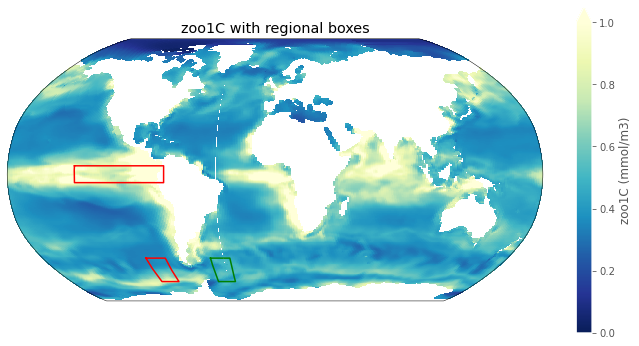

In [31]:
#lon, lat, field = adjust_pop_grid(ds_dec16.TLONG.values, ds_dec16.TLAT.values, ds_dec16.SSH)
field = ds.zoo1C.isel(z_t_150m=0,time=0)
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_title('zoo1C with regional boxes')
pc=ax.pcolormesh(lons, lats, 
                 field, vmin=0, vmax=1, 
                 cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())

# box 1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="green", linewidth=1.5,transform=ccrs.PlateCarree())

# box 2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]

ax.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree())
# box 3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree())\

cbar = fig.colorbar(pc, ax=ax,extend='max',label='zoo1C (mmol/m3)')

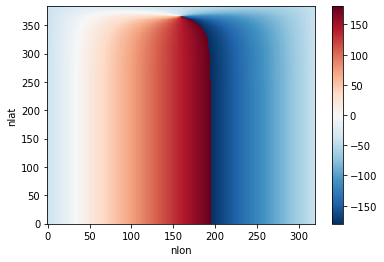

In [11]:
lons_norm=np.full((384, 320), np.nan)

lons_norm_firstpart = lons.where(lons<=180.)
lons_norm_secpart = lons.where(lons>180.) - 360.

lons_norm_firstpart = np.asarray(lons_norm_firstpart)
lons_norm_secpart = np.asarray(lons_norm_secpart)

lons_norm[~np.isnan(lons_norm_firstpart)] = lons_norm_firstpart[~np.isnan(lons_norm_firstpart)]
lons_norm[~np.isnan(lons_norm_secpart)] = lons_norm_secpart[~np.isnan(lons_norm_secpart)]
lons_norm=xr.DataArray(lons_norm)
lons_norm=lons_norm.rename({'dim_0':'nlat'})
lons_norm=lons_norm.rename({'dim_1':'nlon'})
lons_norm.plot();

### Production timeseries: global and then in the boxes

In [12]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.
nmols_to_TgCyr = 1e-9 * 12. * 1e-12 * 365. * 86400.

In [13]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]
variables = variables + ['x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint']

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
#ds_glb

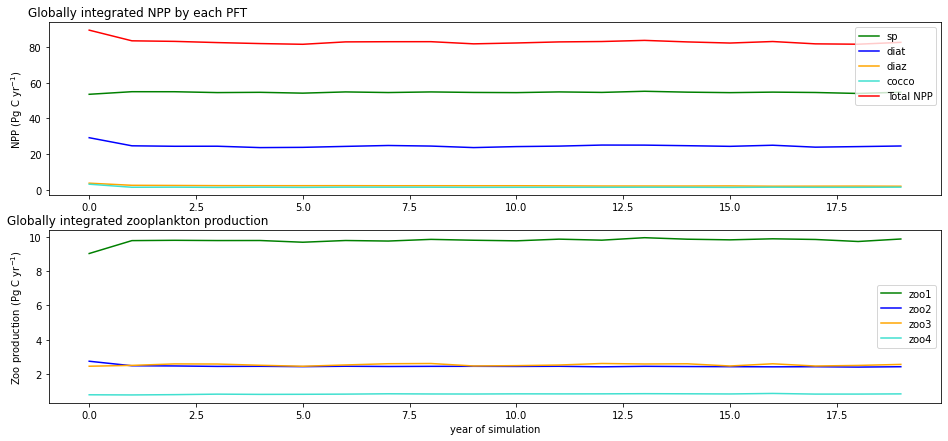

In [14]:
fig = plt.figure(figsize=(16,7))

ax = fig.add_subplot(2,1,1)
ax.set_title('Globally integrated NPP by each PFT',x=0.1)
ax.plot(years,ds_glb['photoC_sp_zint'],color='green',label='sp')
ax.plot(years,ds_glb['photoC_diat_zint'],color='blue',label='diat')
ax.plot(years,ds_glb['photoC_diaz_zint'],color='orange',label='diaz')
ax.plot(years,ds_glb['photoC_cocco_zint'],color='turquoise',label='cocco')
ax.plot(years,ds_glb['photoC_TOT_zint'],color='red',label='Total NPP')

ax.set(ylabel='NPP (Pg C yr$^{-1}$)')
ax.legend()


ax = fig.add_subplot(2,1,2)
ax.set_title('Globally integrated zooplankton production',x=0.1)
ax.plot(years,ds_glb['x_graze_zoo1_zint'],color='green',label='zoo1')
ax.plot(years,ds_glb['x_graze_zoo2_zint'],color='blue',label='zoo2')
ax.plot(years,ds_glb['x_graze_zoo3_zint'],color='orange',label='zoo3')
ax.plot(years,ds_glb['x_graze_zoo4_zint'],color='turquoise',label='zoo4')

ax.set(ylabel='Zoo production (Pg C yr$^{-1}$)',xlabel='year of simulation')
ax.legend();

#### in box 1 in the SW Atlantic (off antarctic peninsula) and box 2 in the SE Pacific

In [18]:
mask = area.where(lats>box1_latmin).where(lats<box1_latmax)
mask = mask.where(lons_norm>box1_lonmin).where(lons_norm<box1_lonmax)

mask2 = area.where(lats>box2_latmin).where(lats<box2_latmax)
mask2 = mask2.where(lons_norm>box2_lonmin).where(lons_norm<box2_lonmax)

mask3 = area.where(lats>box3_latmin).where(lats<box3_latmax)
mask3 = mask3.where(lons_norm>box3_lonmin).where(lons_norm<box3_lonmax)

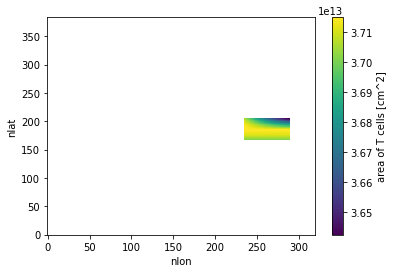

In [19]:
mask3.plot()

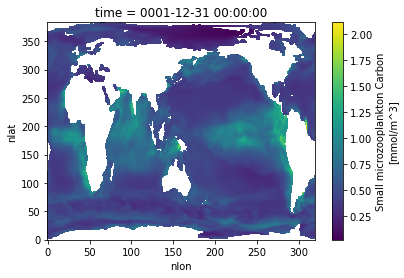

In [17]:
ds.zoo1C.isel(z_t_150m=0,time=0).plot()

In [20]:
ds_sw_atl = xr.Dataset()

for v in variables:
    ds_sw_atl[v] = esmlab.statistics.weighted_sum(ds[v].where(mask>0.), weights=area, dim=['nlat', 'nlon'])
    ds_sw_atl[v].attrs = ds[v].attrs

    ds_sw_atl[v] = ds_sw_atl[v] * nmols_to_TgCyr        
    ds_sw_atl[v].attrs['units'] = 'Tg C yr$^{-1}$'

ds_sw_atl = ds_sw_atl.compute()


In [21]:
ds_se_pac = xr.Dataset()

for v in variables:
    ds_se_pac[v] = esmlab.statistics.weighted_sum(ds[v].where(mask2>0.), weights=area, dim=['nlat', 'nlon'])
    ds_se_pac[v].attrs = ds[v].attrs

    ds_se_pac[v] = ds_se_pac[v] * nmols_to_TgCyr        
    ds_se_pac[v].attrs['units'] = 'Tg C yr$^{-1}$'

ds_se_pac = ds_se_pac.compute()

In [22]:
ds_eeq_pac = xr.Dataset()

for v in variables:
    ds_eeq_pac[v] = esmlab.statistics.weighted_sum(ds[v].where(mask3>0.), weights=area, dim=['nlat', 'nlon'])
    ds_eeq_pac[v].attrs = ds[v].attrs

    ds_eeq_pac[v] = ds_eeq_pac[v] * nmols_to_TgCyr        
    ds_eeq_pac[v].attrs['units'] = 'Tg C yr$^{-1}$'

ds_eeq_pac = ds_eeq_pac.compute()

In [23]:
style.use('ggplot')

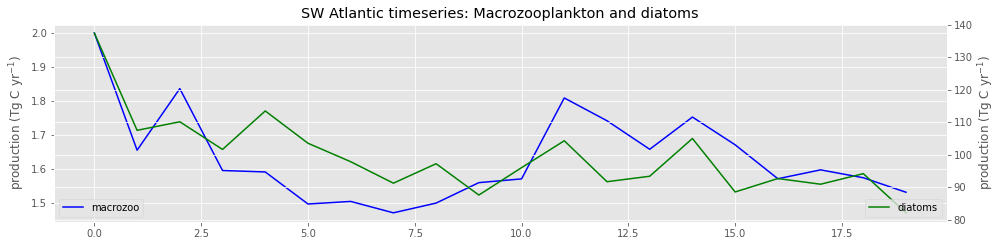

In [24]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,1,1)
ax.set_title('SW Atlantic timeseries: Macrozooplankton and diatoms')
ax.plot(years,ds_sw_atl['x_graze_zoo4_zint'],color='blue',label='macrozoo')
ax.set(ylabel='production (Tg C yr$^{-1}$)')
ax.legend(loc='lower left')
#ax = fig.add_subplot(2,1,2)
ax = ax.twinx()
ax.plot(years,ds_sw_atl['photoC_diat_zint'],color='green',label='diatoms')
ax.set(ylabel='production (Tg C yr$^{-1}$)',xlabel='year of simulation')
ax.legend(loc='lower right');

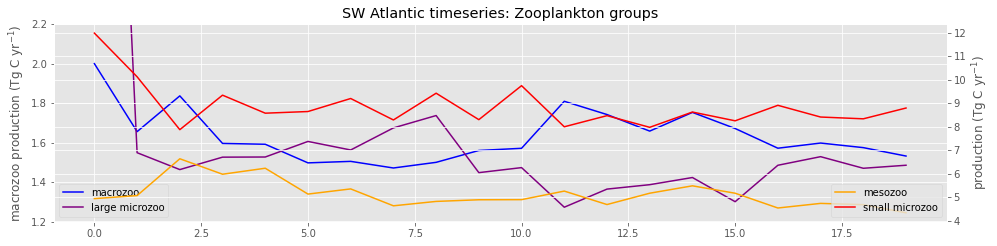

In [102]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,1,1)
ax.set_title('SW Atlantic timeseries: Zooplankton groups')
ax.plot(years,ds_sw_atl['x_graze_zoo4_zint'],color='blue',label='macrozoo')
ax.plot(years,ds_sw_atl['x_graze_zoo2_zint'],color='purple',label='large microzoo')
ax.set(ylabel='macrozoo production (Tg C yr$^{-1}$)')
ax.legend(loc='lower left')
ax.set_ylim(1.2,2.2)

ax = ax.twinx()

ax.plot(years,ds_sw_atl['x_graze_zoo3_zint'],color='orange',label='mesozoo')
# ax.plot(years,ds_sw_atl['x_graze_zoo2_zint'],color='purple',label='large microzoo')
ax.plot(years,ds_sw_atl['x_graze_zoo1_zint'],color='red',label='small microzoo')

ax.set(ylabel='production (Tg C yr$^{-1}$)',xlabel='year of simulation')

ax.legend(loc='lower right');

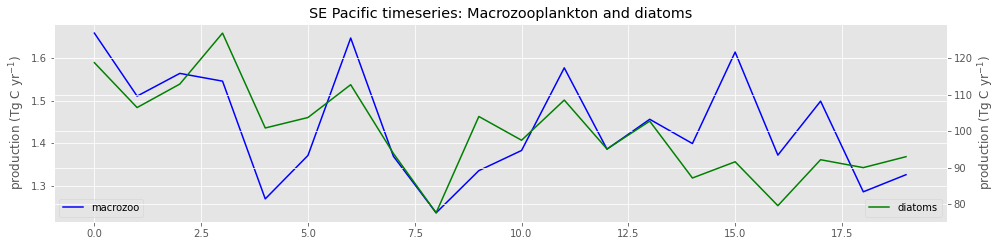

In [103]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,1,1)
ax.set_title('SE Pacific timeseries: Macrozooplankton and diatoms')
ax.plot(years,ds_se_pac['x_graze_zoo4_zint'],color='blue',label='macrozoo')
ax.set(ylabel='production (Tg C yr$^{-1}$)')
ax.legend(loc='lower left')
#ax = fig.add_subplot(2,1,2)
ax = ax.twinx()
ax.plot(years,ds_se_pac['photoC_diat_zint'],color='green',label='diatoms')
ax.set(ylabel='production (Tg C yr$^{-1}$)',xlabel='year of simulation')
ax.legend(loc='lower right');

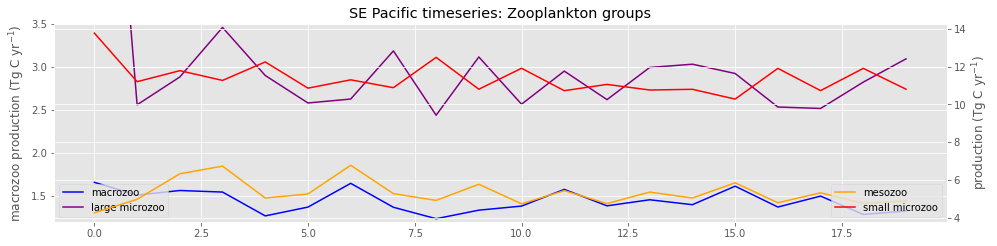

In [110]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,1,1)
ax.set_title('SE Pacific timeseries: Zooplankton groups')
ax.plot(years,ds_se_pac['x_graze_zoo4_zint'],color='blue',label='macrozoo')
ax.plot(years,ds_se_pac['x_graze_zoo2_zint'],color='purple',label='large microzoo')
ax.set(ylabel='macrozoo production (Tg C yr$^{-1}$)')
ax.legend(loc='lower left')
ax.set_ylim(1.2,3.5)

ax = ax.twinx()

ax.plot(years,ds_se_pac['x_graze_zoo3_zint'],color='orange',label='mesozoo')
#ax.plot(years,ds_se_pac['x_graze_zoo2_zint'],color='purple',label='large microzoo')
ax.plot(years,ds_se_pac['x_graze_zoo1_zint'],color='red',label='small microzoo')

ax.set(ylabel='production (Tg C yr$^{-1}$)',xlabel='year of simulation')

ax.legend(loc='lower right');

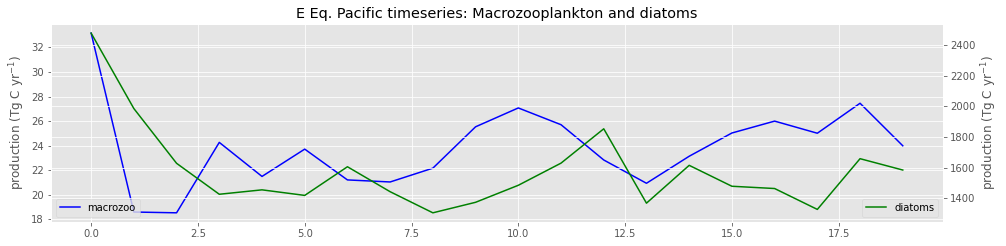

In [25]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,1,1)
ax.set_title('E Eq. Pacific timeseries: Macrozooplankton and diatoms')
ax.plot(years,ds_eeq_pac['x_graze_zoo4_zint'],color='blue',label='macrozoo')
ax.set(ylabel='production (Tg C yr$^{-1}$)')
ax.legend(loc='lower left')
#ax = fig.add_subplot(2,1,2)
ax = ax.twinx()
ax.plot(years,ds_eeq_pac['photoC_diat_zint'],color='green',label='diatoms')
ax.set(ylabel='production (Tg C yr$^{-1}$)',xlabel='year of simulation')
ax.legend(loc='lower right');

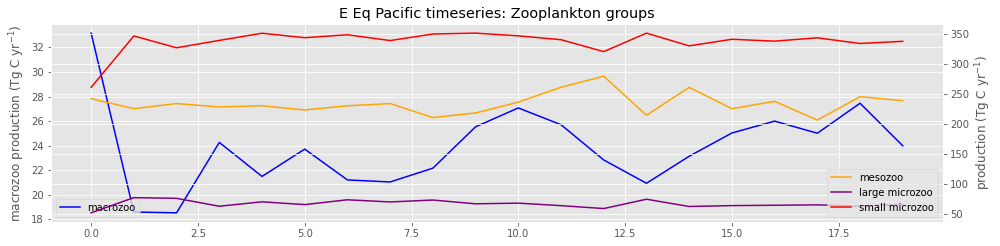

In [30]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(2,1,1)
ax.set_title('E Eq Pacific timeseries: Zooplankton groups')
ax.plot(years, ds_eeq_pac['x_graze_zoo4_zint'],color='blue',label='macrozoo')
#ax.plot(years,ds_eeq_pac['x_graze_zoo2_zint'],color='purple',label='large microzoo')
#ax.plot(years,ds_eeq_pac['x_graze_zoo3_zint'],color='orange',label='mesozoo')
ax.set(ylabel='macrozoo production (Tg C yr$^{-1}$)')
ax.legend(loc='lower left')
#ax.set_ylim(1.2,3.5)

ax = ax.twinx()

ax.plot(years,ds_eeq_pac['x_graze_zoo3_zint'],color='orange',label='mesozoo')
ax.plot(years,ds_eeq_pac['x_graze_zoo2_zint'],color='purple',label='large microzoo')
ax.plot(years,ds_eeq_pac['x_graze_zoo1_zint'],color='red',label='small microzoo')

ax.set(ylabel='production (Tg C yr$^{-1}$)',xlabel='year of simulation')

ax.legend(loc='lower right');

## Hovmöller diagrams of nutient/O2 biases (depth versus time)

In [112]:
grid_name = 'POP_gx1v7'
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d_basins = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

#### WOA for making biases

In [113]:
woa_Pac = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=2
woa_Pac['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Pac['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [114]:
woa_Atl = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
regnum=1
woa_Atl['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
woa_Atl['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

In [115]:
woa_global = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_global['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
woa_global['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [116]:
woa_SO = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_SO['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['O2'] = esmlab.weighted_mean(ds_woa['O2'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['NO3'] = esmlab.weighted_mean(ds_woa['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['PO4'] = esmlab.weighted_mean(ds_woa['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

#### CESM timeseries: Pacific, Alantic, global, Southern Ocean

Southern Ocean

In [145]:
ts_SO = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_SO['SiO3'] = esmlab.weighted_mean(ds['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO['O2'] = esmlab.weighted_mean(ds['O2'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO['PO4'] = esmlab.weighted_mean(ds['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO['NO3'] = esmlab.weighted_mean(ds['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [146]:
diff_SO = ts_SO - woa_SO
diff_SO=diff_SO.transpose()
diff_SO_top=diff_SO.isel(z_t=slice(0,40))
diff_SO_bottom=diff_SO.isel(z_t=slice(40,60))

Pacific

In [147]:
%%time
regnum=2
ts_Pac = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_Pac['O2'] = esmlab.weighted_mean(ds['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['PO4'] = esmlab.weighted_mean(ds['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['NO3'] = esmlab.weighted_mean(ds['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Pac['SiO3'] = esmlab.weighted_mean(ds['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 8.83 s, sys: 6.54 s, total: 15.4 s
Wall time: 12.7 s


In [148]:
diff_Pac = ts_Pac - woa_Pac
diff_Pac=diff_Pac.transpose()
diff_Pac_top=diff_Pac.isel(z_t=slice(0,40))
diff_Pac_bottom=diff_Pac.isel(z_t=slice(40,60))

Atlantic

In [149]:
%%time
regnum=1
ts_Atl = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_Atl['O2'] = esmlab.weighted_mean(ds['O2']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['PO4'] = esmlab.weighted_mean(ds['PO4']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['NO3'] = esmlab.weighted_mean(ds['NO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()
ts_Atl['SiO3'] = esmlab.weighted_mean(ds['SiO3']*mask3d_basins.isel(region=regnum), weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 8.79 s, sys: 6.51 s, total: 15.3 s
Wall time: 9.43 s


In [150]:
diff_Atl = ts_Atl - woa_Atl
diff_Atl=diff_Atl.transpose()
diff_Atl_top=diff_Atl.isel(z_t=slice(0,40))
diff_Atl_bottom=diff_Atl.isel(z_t=slice(40,60))

Global

In [151]:
%%time
ts_global = xr.Dataset({v: ds[v] for v in ['time','z_t']})
ts_global['O2'] = esmlab.weighted_mean(ds['O2'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['PO4'] = esmlab.weighted_mean(ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['NO3'] = esmlab.weighted_mean(ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_global['SiO3'] = esmlab.weighted_mean(ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

CPU times: user 7.96 s, sys: 5.49 s, total: 13.5 s
Wall time: 8.15 s


In [152]:
diff_global = ts_global - woa_global
diff_global=diff_global.transpose()
diff_global_top=diff_global.isel(z_t=slice(0,40))
diff_global_bottom=diff_global.isel(z_t=slice(40,60))

#### Set up dims for plotting

In [153]:
z_top=depths_m.isel(z_t=slice(0,40))
z_bottom=depths_m.isel(z_t=slice(40,60))

## O$_2$

#### Plot Pacific O$_2$ bias

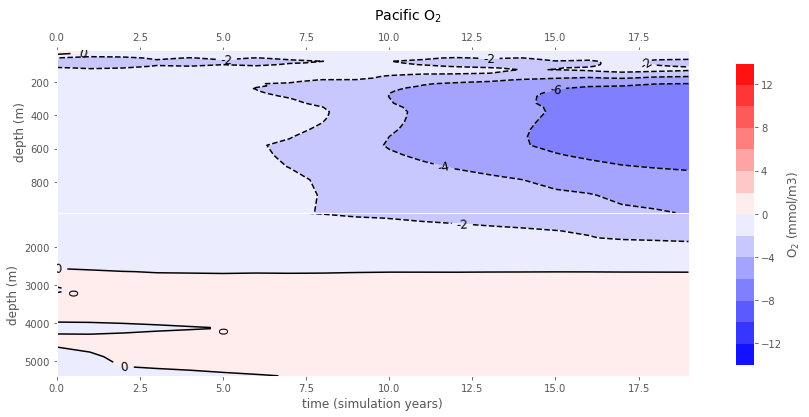

In [154]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14]
pc=ax.contourf(years, z_top, diff_Pac_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Pac_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

#### Plot Atlantic O2 bias

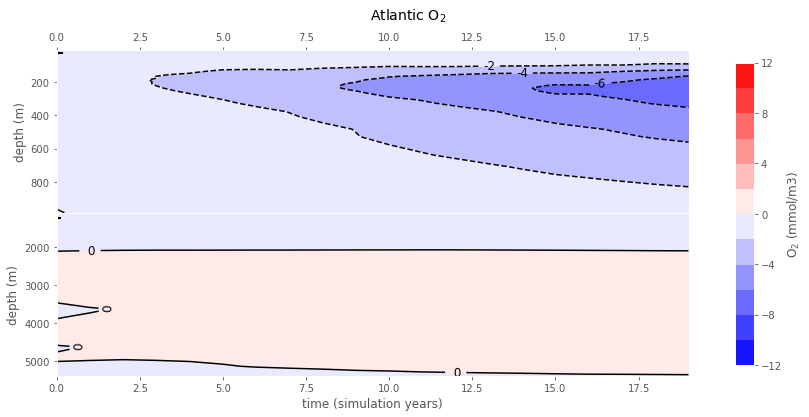

In [155]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
pc=ax.contourf(years, z_top, diff_Atl_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_Atl_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

#### Plot Global O2 bias

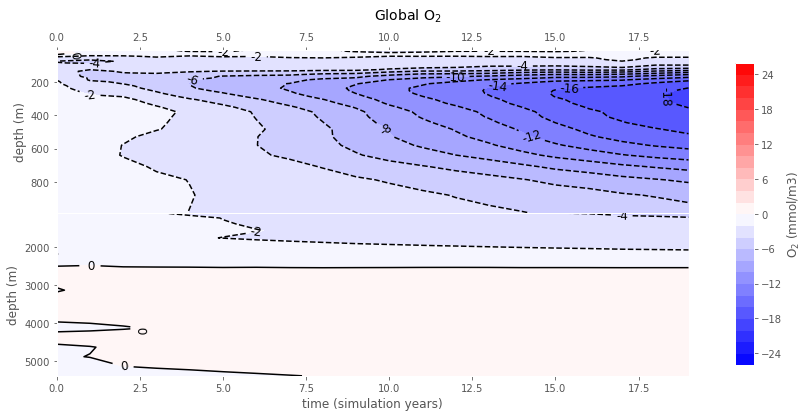

In [156]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global O$_2$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-26,-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26]
pc=ax.contourf(years, z_top, diff_global_top['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_global_top['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['O2'], levels, cmap='bwr')
contour = plt.contour(years, z_bottom, diff_global_bottom['O2'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='O$_2$ (mmol/m3)')

## NO$_3$

#### Plot Pacific NO$_3$ bias

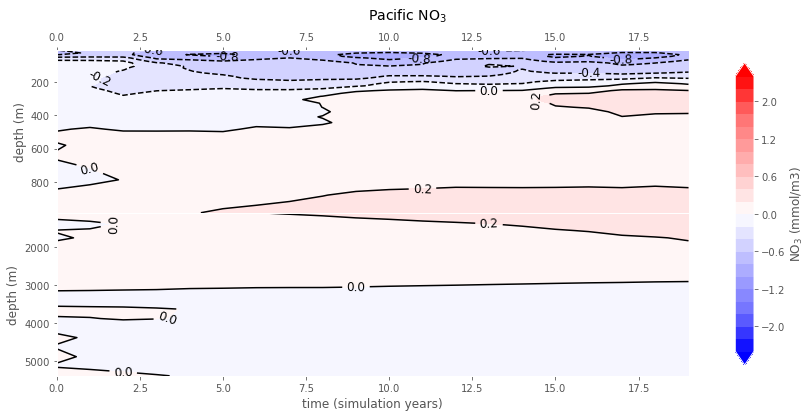

In [130]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-2.8,-2.4,-2,-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,2.4,2.8]
pc=ax.contourf(years, z_top, diff_Pac_top['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Pac_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)',extend='both')

#### Plot Atlantic NO$_3$ bias

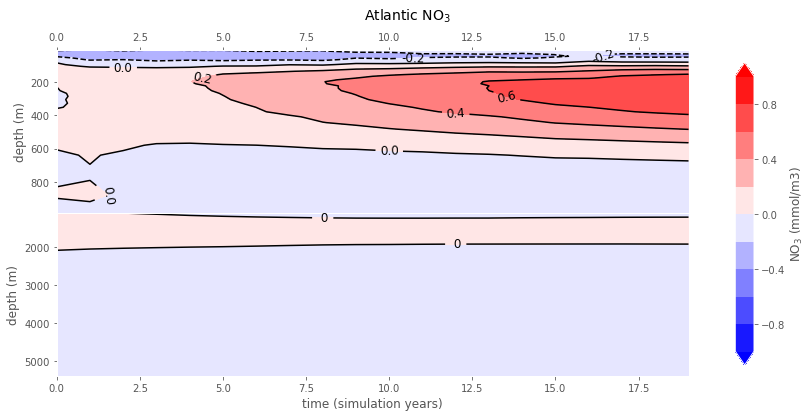

In [131]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
pc=ax.contourf(years, z_top, diff_Atl_top['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Atl_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)',extend='both')

#### Global NO$_3$ bias

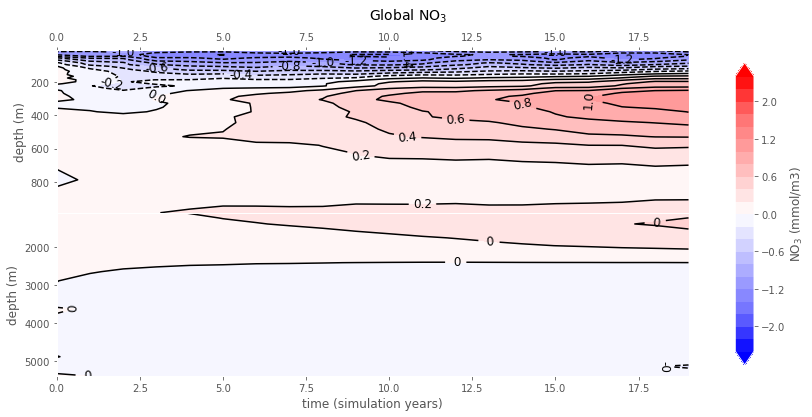

In [132]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global NO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-2.8,-2.4,-2,-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,2.4,2.8]
pc=ax.contourf(years, z_top, diff_global_top['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_global_top['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['NO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_global_bottom['NO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO$_3$ (mmol/m3)',extend='both')

## SiO$_3$

#### Atlantic SiO$_3$ bias

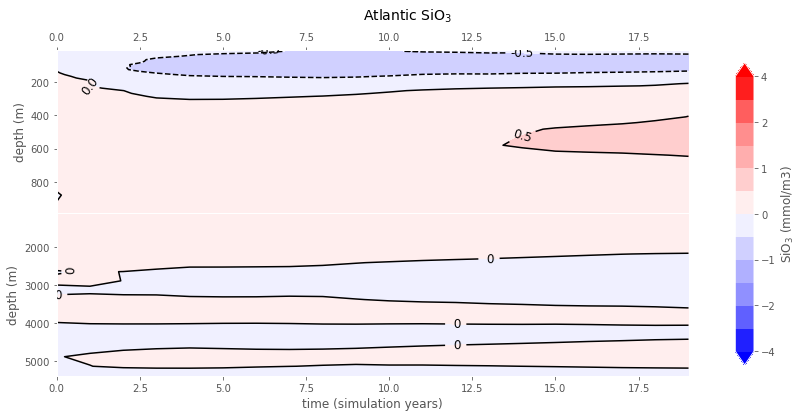

In [133]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-4, -3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]
pc=ax.contourf(years, z_top, diff_Atl_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Atl_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

#### Pacific SiO$_3$ bias

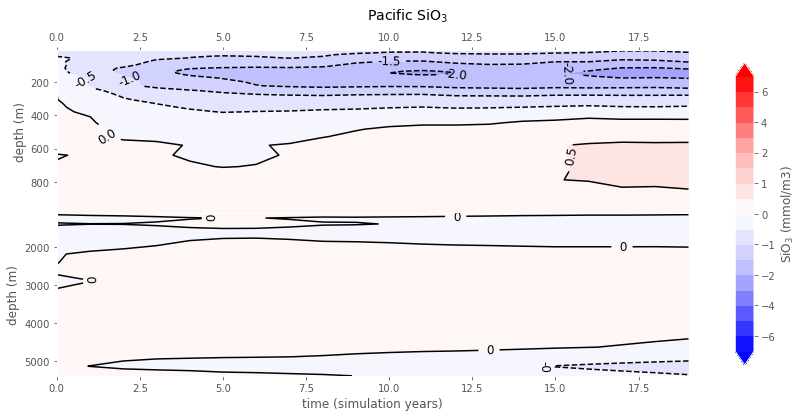

In [134]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4, -3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_Pac_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Pac_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

#### Global SiO$_3$ bias

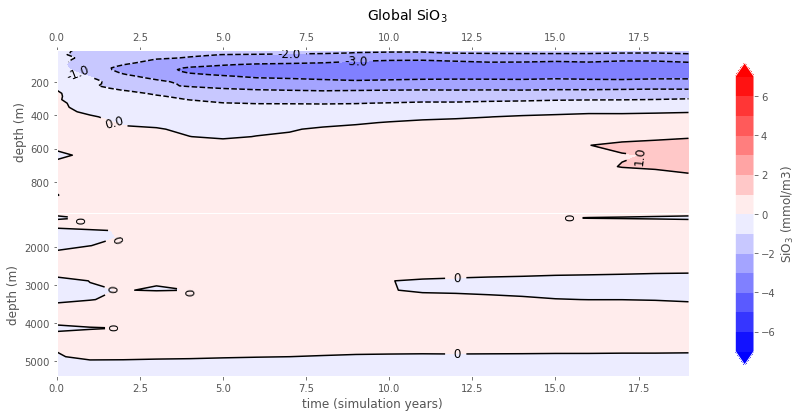

In [135]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
pc=ax.contourf(years, z_top, diff_global_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_global_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_global_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

### Southern Ocean SiO$_3$ bias

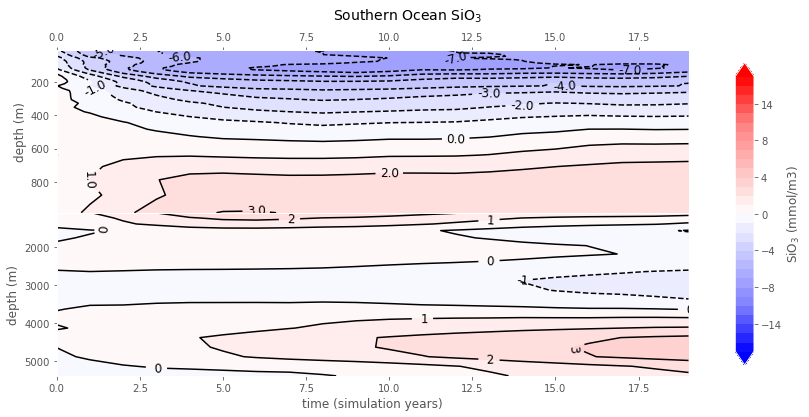

In [136]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern Ocean SiO$_3$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-20,-18,-16,-14,-12,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
pc=ax.contourf(years, z_top, diff_SO_top['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_SO_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_SO_bottom['SiO3'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_SO_bottom['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ (mmol/m3)',extend='both')

## PO$_4$

#### Atlantic PO$_4$ bias

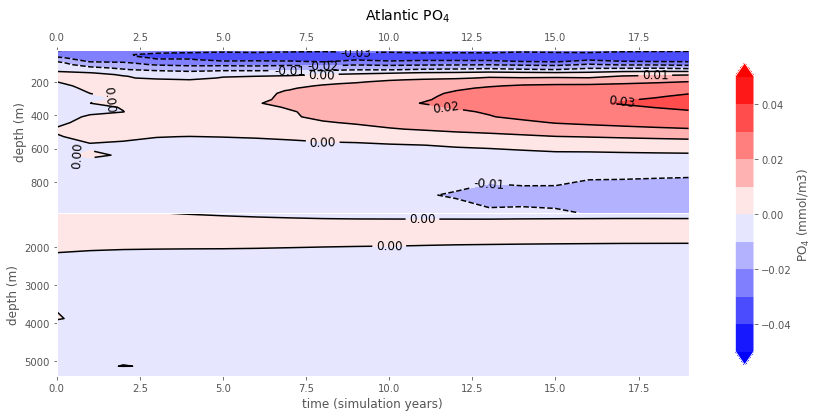

In [137]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Atlantic PO$_4$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]
pc=ax.contourf(years, z_top, diff_Atl_top['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Atl_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Atl_bottom['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Atl_bottom['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ (mmol/m3)',extend='both')

#### Pacific PO$_4$ bias

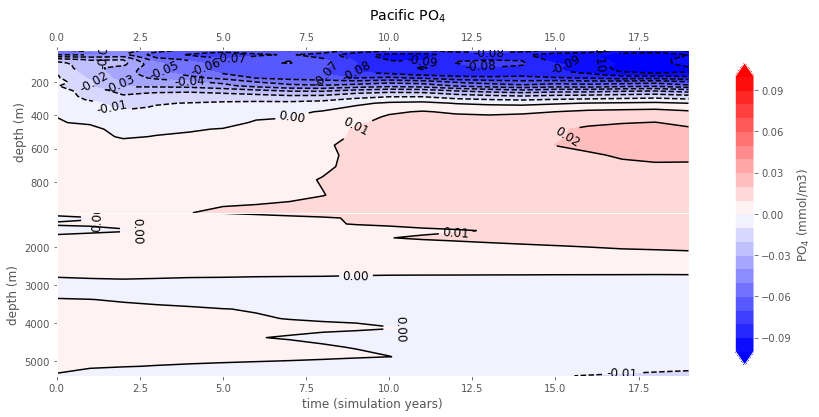

In [138]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Pacific PO$_4$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-0.1,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
pc=ax.contourf(years, z_top, diff_Pac_top['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_Pac_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_Pac_bottom['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_Pac_bottom['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ (mmol/m3)',extend='both')

#### Global PO$_4$ bias

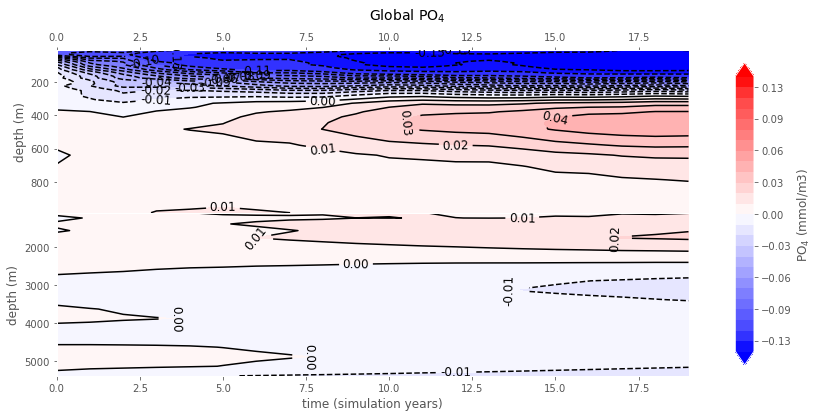

In [139]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Global PO$_4$', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = [-0.15,-0.13,-0.11,-0.1,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.13,0.15]
pc=ax.contourf(years, z_top, diff_global_top['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_top, diff_global_top['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, diff_global_bottom['PO4'], levels, cmap='bwr',extend='both')
contour = plt.contour(years, z_bottom, diff_global_bottom['PO4'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='PO$_4$ (mmol/m3)',extend='both')